## Sample Analysis for Tracker Observables

Begin by importing the allmighty `numpy` and `pyplot`

In [1]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import matplotlib.image as img
import random 

from os import listdir
import re

# Weight Events

Small bit of code which weights the simulated muon neutrinos according to the expected number of events at FaserNu

In [2]:
def weight_muon_neutrinos(data):
    
    # Import data for the number of expected muon neutrino interactions during run 3
    expectedData1 = np.loadtxt('FluenceFiles/FASER_-14.txt')
    expectedData2 = np.loadtxt('FluenceFiles/FASER_14.txt')
    
    expEnergy = expectedData1[:,0]
    expTotal  = (expectedData1[:,1] + expectedData2[:,1]) / 150 # To normalize to 1 fb^-1
    
    # Setup variables for weighting neutrino events.
    volFlu  = 25 * 25 * 100  # Volume of tungsten target used for FASER_-14.txt file
    rhoTung = 19.3           # Density of tungsten
    volTung = 25 * 30 * 106  # Volume of tungsten target used in FLUKA simulation
    rhoLead = 11.35          # Density of lead
    volLead = 30 * 40 * 10   # Volume of lead shielding used in FLUKA simulation
    
    # Weight by the masses of the targets
    tungWeight = (volTung/volFlu)
    leadWeight = volLead/volFlu * rhoLead/rhoTung
    
    # Weight per primary
    numSimTung = 13 * 1000
    numSimLead = 5 * 1000
    
    # Simulation energies are close to those in FASER_-14.txt
    # Use a small buffer to ensure there is a match
    eps  = 0.01 # Within 10 MeV
    for event in data:
        if event.get('weight') is None:
            energy = event['primaryEnergy']
            zpos   = event['zposition']

            mask = (expEnergy < (energy + eps)) & (expEnergy > (energy - eps))
            numExp = expTotal[mask]
            if zpos < 120: # If interacted in tungsten
                weight = tungWeight * numExp / numSimTung
            else:
                weight = leadWeight * numExp / numSimLead

            event['weight'] = weight[0] # Method with the mask returns a numpy array with one-element


def weight_muons(files):
    
    data = np.array([])
    
    # Load fluence files for muons and anti-muons and combine them
    expectedData1 = np.loadtxt('FluenceFiles/negative_muon_flux.csv')
    expectedData2 = np.loadtxt('FluenceFiles/positive_muon_flux.csv')
    
    expEnergy = expectedData1[:,0]
    expFlu    = expectedData1[:,1] + expectedData2[:,1]
    
    # expFlu has units of GeV^-1 cm^-2 s^-1
    # Multiply by primary energy to change to cm^-2 s^-1
    expFlu = expFlu * expEnergy
    
    LHCflu = 2 * (10 ** -5) # fb^-1 s^-1 from LHC
    expFlu = expFlu / LHCflu # fb (at the LHC) * cm^-2 (per unit area at FASER)
    
    A_lr = 6.5 * 35 # left/right simulation area in cm^2
    A_tb = 43  * 4 # top/bot simulation area in cm^2
    
    expTot_lr = expFlu * A_lr
    expTot_tb = expFlu * A_tb
    
    # Number simulated in each region for each input file
    num_lr = 21527
    num_tb = 21527
    
    simTot_lr = num_lr * len([[] for file in files if re.search(r'.*left.*',file)])
    simTot_tb = num_tb * len([[] for file in files if re.search(r'.*top.*',file)])
    
    # Controls accepted range for matching primary energy - Anything below ~200 GeV should be identical
    eps  = 0.01 # Within 10 MeV
    
    for file in files:
        tmp = np.load('NumpyArrays/' + file, allow_pickle=True)
        if re.search(r'.*left.*',file):
            simTot = simTot_lr
            expTot = expTot_lr
        elif re.search(r'.*right.*',file):
            simTot = simTot_lr
            expTot = expTot_lr
        else:
            simTot = simTot_tb
            expTot = expTot_tb
        
        # Add the appropriate weight to each event
        for event in tmp:
            energy = event['primaryEnergy']
            
            # Find which energy this primary falls into
            mask = (expEnergy < (energy + eps)) & (expEnergy > (energy - eps))
            # Number of expected muons at this energy
            numExp = expTot[mask]
            # weight = number expected / number simulated
            event['weight'] = numExp[0] / simTot # Weight for 1 fb^-1 run at the LHC
        
        data = np.append(data,tmp)
    
    return data

The following block of code runs the weighting function on the muon neutrino data and muon data in the `NumpyArrays` directory.

In [3]:
# Run the weighting function on each data file and save the result
ls = listdir('NumpyArrays/')

files = [file for file in ls if re.search(r'muon_neutrinos',file)]
muon_neutrino_data = np.array([])
for file in files:
    tmp = np.load('NumpyArrays/' + file, allow_pickle=True)
    weight_muon_neutrinos(tmp)
    np.save('NumpyArrays/' + file, tmp)
    
    muon_neutrino_data = np.append(muon_neutrino_data, tmp)

files = [file for file in ls if re.search(r'muons',file)]
muon_data = weight_muons(files)

In [21]:
objects = []
for event in muon_data:
    tmp = {'energy': np.round(event['primaryEnergy'],-2),
           'weight': np.round(event['weight']*5,3)}
    if not(tmp in objects):
        objects.append(tmp)  
sorted(objects, key=lambda d: d['energy']) 

[{'energy': 100.0, 'weight': 2.238},
 {'energy': 100.0, 'weight': 2.96},
 {'energy': 300.0, 'weight': 1.865},
 {'energy': 300.0, 'weight': 1.41},
 {'energy': 500.0, 'weight': 0.631},
 {'energy': 500.0, 'weight': 0.835},
 {'energy': 700.0, 'weight': 0.321},
 {'energy': 700.0, 'weight': 0.424},
 {'energy': 900.0, 'weight': 0.362},
 {'energy': 900.0, 'weight': 0.479},
 {'energy': 1100.0, 'weight': 0.821},
 {'energy': 1100.0, 'weight': 0.621},
 {'energy': 1300.0, 'weight': 0.774},
 {'energy': 1300.0, 'weight': 1.024},
 {'energy': 1500.0, 'weight': 0.65},
 {'energy': 1500.0, 'weight': 0.86},
 {'energy': 1700.0, 'weight': 0.59},
 {'energy': 1700.0, 'weight': 0.446},
 {'energy': 1900.0, 'weight': 0.406},
 {'energy': 1900.0, 'weight': 0.307},
 {'energy': 2100.0, 'weight': 0.257},
 {'energy': 2100.0, 'weight': 0.34},
 {'energy': 2300.0, 'weight': 0.228},
 {'energy': 2300.0, 'weight': 0.301},
 {'energy': 2500.0, 'weight': 0.239},
 {'energy': 2500.0, 'weight': 0.316},
 {'energy': 2700.0, 'weight'

### Display event

Here is some quick event display function I wrote based on Michael's code

In [5]:
def display_event(data, ievent=0):
    
    #load event
    event = data[ievent]
    if event['scintillator'][0]> 0: return 0
    if event['scintillator'][2]==0: return 0 
    
    # initialize
    multiplier=2
    matplotlib.rcParams.update({'font.size': 15*multiplier})
    matplotlib.rcParams['axes.linewidth'] = multiplier
    fig = plt.figure(figsize=(16*multiplier,7*multiplier))
    
    # Setup some nice axes 
    x0, x1 = 0.01, 0.94
    width = (x1-x0)/4
    h_tr, h_pic, h_sc = 0.55, 0.35, 0.08
    ax0 = fig.add_axes([x0          , 0.02+h_tr      , (x1-x0)   , h_pic])    
    ax1 = fig.add_axes([x0 + 0*width, 0.02           , width     , h_tr ])
    ax2 = fig.add_axes([x0 + 1*width, 0.02           , width     , h_tr ])
    ax3 = fig.add_axes([x0 + 2*width, 0.02           , width     , h_tr ])
    ax4 = fig.add_axes([x0 + 3*width, 0.02           , 1.25*width, h_tr ])
    ax5 = fig.add_axes([x0          , 0.02+h_tr+h_pic, 0.8       , 0.05  ])
    ax6 = fig.add_axes([x0+0.8      , 0.02+h_tr+h_pic, x1-x0-0.8 , 0.05  ])
    
    #plot image of detector
    image = img.imread('Fig_Layout.jpg')
    ax0.imshow(image)
    ax0.set_xticks([])
    ax0.set_yticks([])
    ax0.spines.clear()
    
    # Plot the tracker images
    bins = (np.linspace(-12.5, 12.5, 26),np.linspace(-12.5, 12.5, 26))
    for ax, layer in zip([ax1,ax2,ax3,ax4],['hits1','hits2','hits3','hits4']):
        image = np.array(event[layer])
        if len(image)==0: image = np.array([[0,0,0]])
        hist = ax.hist2d(image.T[0], image.T[1], weights=image.T[2], bins=bins, 
                  norm=matplotlib.colors.LogNorm(vmin=1,vmax=100),cmap='cool')
        ax.set_xticks([])
        ax.set_yticks([])
    fig.colorbar(hist[3], ax=ax4)
    
    # Plot scintillators
    ax5.hist2d(np.linspace(0.5,8.5,9), np.zeros(9) , weights=event['scintillator'][:-1], bins=(np.linspace(0,9,10),[-1,1]), 
                  norm=matplotlib.colors.LogNorm(vmin=0.1,vmax=1),cmap='rainbow')
    for x in np.linspace(0,8,9): 
        ax5.plot([x,x],[-1,1],lw=multiplier,c="k")
        ax5.text(x+0.06,-0.75,str(int(x+1)))
    ax5.set_xticks([])
    ax5.set_yticks([])
    
    # Plot calorimeter
    ax6.text(0.5,0.5,"E="+str(event['calorimeter'])+" GeV",ha="center", va="center")
    ax6.fill([0,1,1,0], [0,0,1,1], c="lightgreen")
    ax6.set_xlim(0,1)
    ax6.set_ylim(0,1)
    ax6.set_xticks([])
    ax6.set_yticks([])

    # Return figure so user can manipulate or save the plots
#     plt.savefig("EventDisplays/Event_"+str(ievent)+".pdf")
#     plt.show()
    
    return 1


In [6]:
# numevents = 0 
# while numevents < 1:
#     ievent = random.randrange(len(muon_neutrino_data))
#     numevents+=display_event(muon_neutrino_data, ievent=ievent)

In [7]:
# # Doing the same thing for muon data
# numevents = 0 
# while numevents < 1:
#     ievent = random.randrange(len(muon_data))
#     numevents+=display_event(muon_data, ievent=ievent)

# Scintillators and Calorimeter Energy

In [8]:
def emptyBarPlot(bins, counts):
    bins2 = np.append(bins,bins)
    bins2[0:len(bins2):2] = bins
    bins2[1:(len(bins2)-1):2] = bins[1:]

    counts2 = np.append(counts,counts)
    counts2[0:len(counts2):2] = counts
    counts2[1:len(counts2):2] = counts
    plt.plot(bins2, counts2)

In [9]:
def countSignalEvents(data, signal = [0, 0, 1, 1, 1, 1, 1, 1, 1, 1], entries = [n for n in range(10)], minCal = 0):
    signal = np.array(signal)
    entries = np.array(entries)

    matches = [event for event in data if (event['scintillator'][entries] == signal).all()]
    count = 0
    for event in matches:
        if event['calorimeter'] > minCal:
            count += event['weight']
    return count

In [10]:
def binSignal(data, bins = None, signal = [0, 0, 1, 1, 1, 1, 1, 1, 1, 1], entries = [n for n in range(10)]):
    signal = np.array(signal)
    entries = np.array(entries)

    matches = [event for event in data if (event['scintillator'][entries] == signal).all()]
    if bins == None:
        deposits = [event['calorimeter'] for event in matches]
        minDep = min(deposits) - 1
        maxDep = max(deposits) + 1
        low = np.log10(max(10**-2, minDep)) # Sets 0.01 as the smallest bin
        high = max(3, np.log10(maxDep)) # Sets 1000 as the largest bin
        bins = np.logspace(low, high, 100)
        
    primEnergies = sorted(set([event['primaryEnergy'] for event in matches]))

    binned = {'bins': bins}

    for energy in primEnergies:
        subdata = [(event['calorimeter'], event['weight']) for event in matches if event['primaryEnergy'] == energy]
        cal = [x[0] for x in subdata]
        weights = [x[1] for x in subdata]
        ids = np.searchsorted(bins,cal)
        wids = zip(ids,weights)

        counts = np.zeros(np.size(bins))
        for wid in wids:
            try:
                counts[wid[0]] += wid[1]
            except IndexError:
                print(wid[0])
                print(energy)
                break

        binned[energy] = counts
        
    return binned

In [11]:
def plotBinnedData(data):
    bins = data['bins']
    energies = [e for e in data.keys() if isinstance(e,float)]
    
    curCounts = np.zeros(np.size(bins))
    for energy in energies:
        counts = data[energy]
        curCounts += counts
        
        emptyBarPlot(bins,curCounts)

CPU times: user 4.86 s, sys: 4.22 ms, total: 4.87 s
Wall time: 4.87 s


Text(0, 0.5, 'Muon Expected Counts for 1 fb^-1')

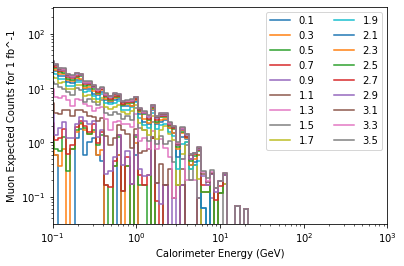

In [17]:
%%time
data1 = binSignal(muon_data)

plotBinnedData(data1)
plt.xscale('log')
plt.yscale('log')
plt.xlim([10**-1, 10**3])
plt.ylim([10**-1.5, 10**2.5])
energies = [e for e in data1.keys() if isinstance(e,float)]
plt.legend([str(np.round(energy,-2)/1000) for energy in energies], ncol=2);
plt.xlabel('Calorimeter Energy (GeV)');
plt.ylabel('Muon Expected Counts for 1 fb^-1');

CPU times: user 914 ms, sys: 87 µs, total: 914 ms
Wall time: 914 ms


Text(0, 0.5, 'Muon Neutrino Expected Counts for 1 fb^-1')

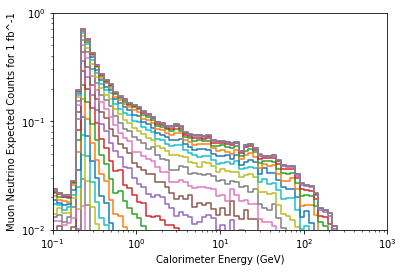

In [20]:
%%time
data2 = binSignal(muon_neutrino_data)

plotBinnedData(data2)
plt.xscale('log')
plt.yscale('log')
plt.xlim([10**-1, 10**3])
plt.ylim([10**-2, 10**0])
energies = [e for e in data2.keys() if isinstance(e,float)]
# plt.legend([str(int(np.round(energy))) for energy in energies], ncol=2);
plt.xlabel('Calorimeter Energy (GeV)');
plt.ylabel('Muon Neutrino Expected Counts for 1 fb^-1');

In [14]:
LHCrun = 5 # in fb^-1
for minCal in [1, 5, 10, 15]:
    print(f'For {LHCrun} fb^-1 and a calorimeter cut = {minCal} GeV:',
      'Muon:', np.round(countSignalEvents(muon_data, minCal = minCal)*LHCrun,1),
      '| Muon Neutrino:', np.round(countSignalEvents(muon_neutrino_data, minCal = minCal)*LHCrun,1))

For 5 fb^-1 and a calorimeter cut = 1 GeV: Muon: 180.9 | Muon Neutrino: 12.9
For 5 fb^-1 and a calorimeter cut = 5 GeV: Muon: 9.9 | Muon Neutrino: 7.0
For 5 fb^-1 and a calorimeter cut = 10 GeV: Muon: 1.7 | Muon Neutrino: 5.1
For 5 fb^-1 and a calorimeter cut = 15 GeV: Muon: 0.3 | Muon Neutrino: 4.1
